In [1]:
#Make python screen wider
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [51]:
!pip install xgboost

     ------------------------------------- 125.4/125.4 MB 14.9 MB/s eta 0:00:00


In [61]:
import numpy as np
import wget
import pandas as pd
import statistics as st
import seaborn as sns
import xgboost as xgb
import re

from scipy import stats

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mutual_info_score, roc_auc_score, mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.tree import DecisionTreeClassifier, export_text, DecisionTreeRegressor

from tqdm.auto import tqdm

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

#increase the width of the line
large_width = 400
np.set_printoptions(linewidth=large_width)

In [6]:
wget.download("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv")

100% [..........................................................................] 1423529 / 1423529

'housing.csv'

In [3]:
df_raw=pd.read_csv('housing.csv')

In [4]:
df_copy = df_raw.copy()

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Loading the data

Use only the following columns:  
* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`,
* `'ocean_proximity'`  

* Fill NAs with 0.
* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer` to turn the dataframe into matrices.

In [6]:
df = df_raw[['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   latitude            20640 non-null  float64
 1   longitude           20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
df.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [9]:
df = df.fillna(0)
df.isna().sum()

latitude              0
longitude             0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

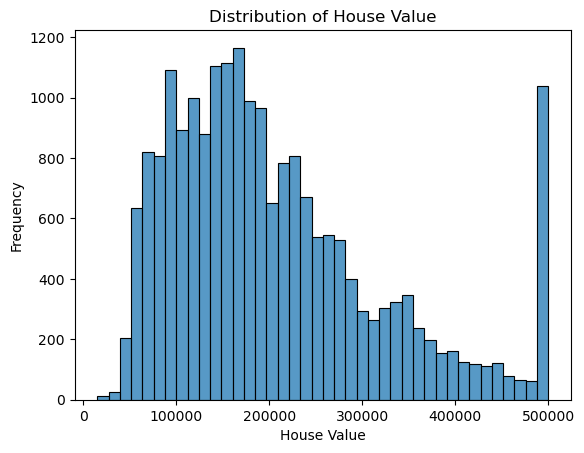

In [10]:
sns.histplot(df.median_house_value, bins=40)
plt.ylabel('Frequency')
plt.xlabel('House Value')
plt.title('Distribution of House Value')
plt.show()

In [11]:
df["median_house_value"] = np.log1p(df.median_house_value.values)

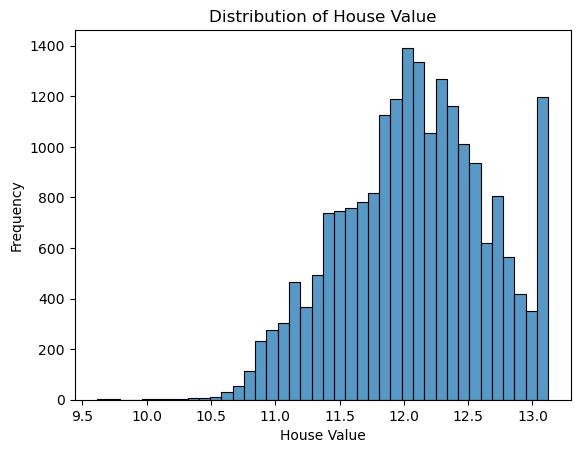

In [12]:
sns.histplot(df.median_house_value, bins=40)
plt.ylabel('Frequency')
plt.xlabel('House Value')
plt.title('Distribution of House Value')
plt.show()

In [13]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
len(df), len(df_train), len(df_val), len(df_test)

(20640, 12384, 4128, 4128)

In [14]:
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

In [15]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [16]:
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train =dv.fit_transform(train_dict)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.

> ANSWER  
  `ocean_proximity=INLAND`

In [17]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [18]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

In [19]:
y_pred = dtr.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print('train:', mse)

train: 0.2181023962679052


In [20]:
print(export_text(dtr, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



D:\Users\Test\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [21]:
y_pred = dtr.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print('val:', mse)

val: 0.2188716880874183


## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.05
* 0.25
* 0.55
* 0.85

> ANSWER  
  `0.25`

In [22]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [23]:
y_pred = rf.predict(X_val)
y_pred

array([12.69611943, 13.08974669, 11.37547351, ..., 12.74865454, 12.32324285, 12.30347243])

In [24]:
round(mean_squared_error(y_val, y_pred, squared=False),2)

0.25

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 150

>ANSWER  
    70

In [25]:
estim = np.arange(10,210,10)
estim

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200])

In [26]:
for estim_val in estim:
    rmse=0
    rf = RandomForestRegressor(n_estimators=estim_val, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    
    rmse = round(mean_squared_error(y_val, y_pred, squared=False),3)

    print('estimator at: ', estim_val, rmse)

estimator at:  10 0.246
estimator at:  20 0.239
estimator at:  30 0.236
estimator at:  40 0.235
estimator at:  50 0.233
estimator at:  60 0.233
estimator at:  70 0.232
estimator at:  80 0.233
estimator at:  90 0.232
estimator at:  100 0.232
estimator at:  110 0.232
estimator at:  120 0.232
estimator at:  130 0.232
estimator at:  140 0.232
estimator at:  150 0.232
estimator at:  160 0.232
estimator at:  170 0.232
estimator at:  180 0.232
estimator at:  190 0.232
estimator at:  200 0.232


## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20
* 25
> ANSWER
20 - because 20 is similar to 25 but it is less complex and it is easy to understand

In [27]:
for max_d in [10,15,20,25]:
    for estim_val in estim:
        rmse=0
        rf = RandomForestRegressor(max_depth = max_d, n_estimators=estim_val, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)

        rmse = round(mean_squared_error(y_val, y_pred, squared=False),3)

        print('max_depth: ', max_d, 'estimator at: ', estim_val, 'rmse is: ', rmse)

max_depth:  10 estimator at:  10 rmse is:  0.255
max_depth:  10 estimator at:  20 rmse is:  0.253
max_depth:  10 estimator at:  30 rmse is:  0.252
max_depth:  10 estimator at:  40 rmse is:  0.251
max_depth:  10 estimator at:  50 rmse is:  0.25
max_depth:  10 estimator at:  60 rmse is:  0.25
max_depth:  10 estimator at:  70 rmse is:  0.25
max_depth:  10 estimator at:  80 rmse is:  0.25
max_depth:  10 estimator at:  90 rmse is:  0.249
max_depth:  10 estimator at:  100 rmse is:  0.249
max_depth:  10 estimator at:  110 rmse is:  0.249
max_depth:  10 estimator at:  120 rmse is:  0.249
max_depth:  10 estimator at:  130 rmse is:  0.249
max_depth:  10 estimator at:  140 rmse is:  0.249
max_depth:  10 estimator at:  150 rmse is:  0.249
max_depth:  10 estimator at:  160 rmse is:  0.249
max_depth:  10 estimator at:  170 rmse is:  0.249
max_depth:  10 estimator at:  180 rmse is:  0.249
max_depth:  10 estimator at:  190 rmse is:  0.249
max_depth:  10 estimator at:  200 rmse is:  0.249
max_depth:  1

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature? 

* `total_rooms`
* `median_income`	
* `total_bedrooms`
* `longitude`

> ANSWER  
median_income

In [44]:
rf5 = RandomForestRegressor(n_estimators=10, max_depth = 20, random_state=1, n_jobs=-1)
rf5.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [48]:
rf5.feature_importances_

array([1.69573183e-02, 3.30938997e-02, 1.01333971e-01, 9.62649876e-02, 3.62912907e-01, 3.00723750e-03, 3.10900842e-01, 3.56806263e-04, 4.48661972e-04, 4.22762446e-03, 3.09180197e-02, 1.90412562e-02, 2.05364687e-02])

In [49]:
labels = dv.get_feature_names()

D:\Users\Test\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<BarContainer object of 13 artists>

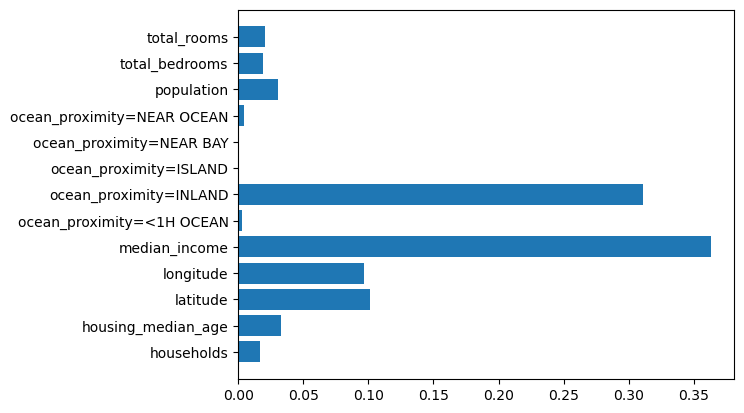

In [50]:
plt.barh(labels, rf5.feature_importances_)

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both gives same
> ANSWER  
  0.3

In [62]:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [65]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain)

In [67]:
y_pred = model.predict(dval)

In [70]:
rmse6 = round(mean_squared_error(y_val, y_pred, squared=False),3)
rmse6

0.432

In [71]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain)

In [73]:
y_pred = model.predict(dval)

In [74]:
rmse6 = round(mean_squared_error(y_val, y_pred, squared=False),3)
rmse6

4.065